# Files necessay to run:

- `PhotoReceptorData.pkl` contains the data describing the photoisomerization rates of the photoreceptors
- `IlluminationDataMEA2.pkl` contains the data describing the illumination of the LEDs
- `cal_with_MEA2_matias.pkl` contains the data describing the (human) white LED and other parameters for voltages computation

In [2]:
# prevents warnings from being printed only in this cell
import warnings
warnings.filterwarnings("ignore")
import pickle

from matplotlib.pyplot import *
from scipy import interpolate

%pylab inline
warnings.filterwarnings("default")

from isomerization_lib import *

%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Load Opsin data

In [3]:
fsave = './PhotoReceptorData'
PhData = load_obj(fsave)                        # Photo Receptors Data

Opsins=[]                                       # Opsins matrix initialization

Opsins.append(PhData['Scones'])                 # S cones
Opsins.append(PhData['Mela'])                   # Melanopsin
Opsins.append(PhData['Rods'])                   # Rods
Opsins.append(PhData['Mcones'])                 # M cones
Opsins.append(PhData['RedOpsin'])               # Red Opsin

x = PhData['x_axis']                            # Wavelength axis

# Creating a dictionary with indexes for each opsin
OpsinIndex = {'S-cone':0,'Melano':1,'Rhodo':2,'M-cone':3,'Redo':4}


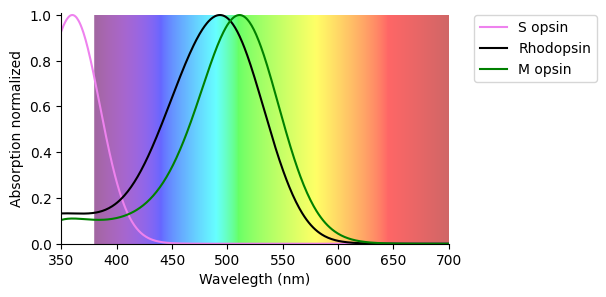

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))

#plot each opsin

ax.plot(x,Opsins[0], color='violet') # S cones
#ax.plot(x,Opsins[1], color='black') # Melanopsin
ax.plot(x,Opsins[2], color='black')  # Rods
ax.plot(x,Opsins[3], color='green')  # M cones
# ax.plot(x,Opsins[4], color='red')    # Red Opsin

# plot a rainbow in the background vertically
# generate a rainbow image
def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 1.0
        G = 1.0
        B = 1.0
    return (R, G, B)

rainbow = np.zeros((len(x),3))
for i in range(len(x)):
    rainbow[i] = wavelength_to_rgb(x[i])

# plot the rainbow
ax.imshow(rainbow.reshape(1,len(x),3), aspect='auto', extent=(min(x),max(x),0,1), alpha=0.6)



ax.set_xlabel('Wavelegth (nm)')    
ax.set_ylabel('Absorption normalized')

ax.set_ylim(0,1.01)

# move legend out of the plot
ax.legend(['S opsin','Rhodopsin','M opsin'], 
            bbox_to_anchor=(1.4, 1.02))


# remove upper and right frame's lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [5]:
# save in png with transparent background

fig.savefig('Opsins.png', transparent=True)

# Load LEDs illumination Data

In [6]:
fsave = './IlluminationDataMEA2'
IData = load_obj(fsave)                                     # Illumination Data Load

LEDs =[]                                                    # LEDs matrix initialization                                
LEDs.append(IData['Violet'])                                # Violet        
LEDs.append(IData['Blue'])                                  # Blue
LEDs.append(IData['Green'])                                 # Green
LEDs.append(IData['Yellow'])                                # Yellow
LEDs.append(IData['Red'])                                   # Red

x = IData['x_axis']                                         # Wavelength axis

# Power meter correction factor from 09/09/22
correction_f = 1                                        

LEDs=np.array(LEDs)/correction_f                            # Correction

In [7]:

# To fix the value of power for the red LED
# You take the value measured and multiply it like below (before you divide by the area under the curve)

USE_CUSTOM_MEASURED_POWER = True

if USE_CUSTOM_MEASURED_POWER:
    newred = 4230
    LEDs[4]  = LEDs[4]/(np.sum(LEDs[4]/2))*newred

    newyellow = 505
    LEDs[3]  = LEDs[3]/(np.sum(LEDs[3]/2))*newyellow

    newgreen = 368
    LEDs[2]  = LEDs[2]/(np.sum(LEDs[2]/2))*newgreen

    newblue = 540
    LEDs[1]  = LEDs[1]/(np.sum(LEDs[1]/2))*newblue

    newviolet = 623
    LEDs[0]  = LEDs[0]/(np.sum(LEDs[0]/2))*newviolet


Text(0, 0.5, 'Power (µW/cm²)')

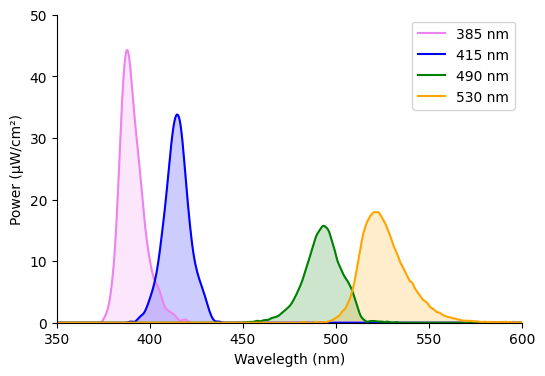

In [8]:
fig , ax = plt.subplots(figsize=(6, 4))


ax.plot(x,LEDs[0], 'violet')
ax.plot(x,LEDs[1], 'blue')
ax.plot(x,LEDs[2], 'green')
ax.plot(x,LEDs[3], 'orange')

# fill under curves

ax.fill_between(x,LEDs[0],color='violet',alpha=0.2)
ax.fill_between(x,LEDs[1],color='blue',alpha=0.2)
ax.fill_between(x,LEDs[2],color='green',alpha=0.2)
ax.fill_between(x,LEDs[3],color='orange',alpha=0.2)
# ax.plot(x,LEDs[4], 'red')

# remove upper and right frame's lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(['385 nm','415 nm','490 nm','530 nm'],
            bbox_to_anchor=(1, 1),
            fontsize=10)

ax.set_ylim([0,50])
ax.set_xlim([350,600])
ax.set_xlabel('Wavelegth (nm)')
ax.set_ylabel('Power (µW/cm²)')


In [9]:

# save as png with transparent background
fig.savefig('LEDs.png', transparent=True)


In [10]:
for i in np.arange(5):
    print(i,np.sum(LEDs[i])/2)

0 623.0
1 539.9999999999999
2 367.99999999999994
3 504.99999999999994
4 4230.0


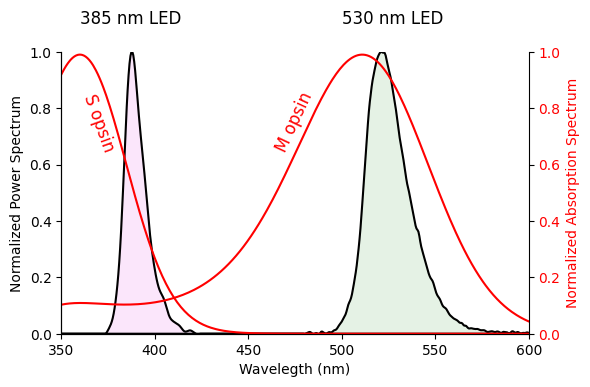

In [133]:
fontsize = 12

fig, ax = plt.subplots(figsize=(6, 4))

normalized_LEDs = [ LEDs[i]/(np.max(LEDs[i])) for i in range(5)]
normalized_opsins = [ Opsins[i]/(np.max(Opsins[i])+0.01) for i in range(5)]

ax.plot(x,normalized_LEDs[0], 'black')
ax.plot(x,normalized_LEDs[3], 'black')

ax.fill_between(x,normalized_LEDs[0],color='violet',alpha=0.2)
ax.fill_between(x,normalized_LEDs[3],color='green',alpha=0.1)

ax.set_ylim([0,1])
ax.set_xlim([350,600])
ax.set_xlabel('Wavelegth (nm)')
ax.set_ylabel('Normalized Power Spectrum')

ax.text(360, 1.1, '385 nm LED', fontsize=fontsize, color='black')
ax.text(500, 1.1, '530 nm LED', fontsize=fontsize, color='black')

# write the name of the opsin on the curve
ax.text(360, 0.65, 'S opsin', fontsize=fontsize, color='red', rotation=-70)
ax.text(463, 0.65, 'M opsin', fontsize=fontsize, color='red', rotation=65)

opsin_ax_color = 'red'

ax_opsin = ax.twinx() 
ax_opsin.set_ylim([0,1])
ax_opsin.tick_params(axis='y', labelcolor=opsin_ax_color)
ax_opsin.set_ylabel('Normalized Absorption Spectrum', color=opsin_ax_color)

#plot each opsin
ax_opsin.plot(x,normalized_opsins[0], color=opsin_ax_color) # S cones
ax_opsin.plot(x,normalized_opsins[3], color=opsin_ax_color)  # M cones

# remove upper and right frame's lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax_opsin.spines['top'].set_visible(False)

plt.tight_layout()

In [134]:
# save image with transparent background as png

fig.savefig('LEDsOpsins.png', transparent=True)

# Calculate Isomerizations

## Compute Isomerization for all opsins for all LEDs sources

In [36]:
print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM VIOLET LED')

# Get effect from Violet
VIOLET_ISO_result = IlluminanceFactor(LEDs[0],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(VIOLET_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM BLUE LED')

# Get effect from Blue
BLUE_ISO_result = IlluminanceFactor(LEDs[1],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(BLUE_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM GREEN LED')

# Get effect from Green
GREEN_ISO_result = IlluminanceFactor(LEDs[2],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(GREEN_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM YELLOW LED')

# Get effect from Yellow
YELLOW_ISO_result = IlluminanceFactor(LEDs[3],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(YELLOW_ISO_result,F=0)

# -----------------------------------------------------------------------------------------------

print ('\n')
print ('-----------------------------')
print ('EFFECTS FROM RED LED')

# Get effect from RED
RED_ISO_result = IlluminanceFactor(LEDs[4],Opsins,x)
print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(RED_ISO_result,F=0)

print ('\n')




-----------------------------
EFFECTS FROM VIOLET LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :    1152076
Melanopsin  :     621078
Rhodopsin   :     947369
Mcones      :     263049
Red_opsin   :     165500


-----------------------------
EFFECTS FROM BLUE LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :     234260
Melanopsin  :     870413
Rhodopsin   :    1493781
Mcones      :     318181
Red_opsin   :     392915


-----------------------------
EFFECTS FROM GREEN LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :         75
Melanopsin  :    1672912
Rhodopsin   :    4433008
Mcones      :    1584489
Red_opsin   :    1083206


-----------------------------
EFFECTS FROM YELLOW LED
Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :          3
Melanopsin  :    1241788
Rhodopsin   :    4548956
Mcones      :    2308388
Red_

In [37]:
# Get effect from All together

ISO_result = IlluminanceFactor(np.sum(LEDs[0:4],axis=0),Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :    1386414
Melanopsin  :    4406191
Rhodopsin   :   11423113
Mcones      :    4474107
Red_opsin   :    3874248

Scones      : 1.39e+06
Melanopsin  : 4.41e+06
Rhodopsin   : 1.14e+07
Mcones      : 4.47e+06
Red_opsin   : 3.87e+06


In [38]:
OpsinIndex

{'S-cone': 0, 'Melano': 1, 'Rhodo': 2, 'M-cone': 3, 'Redo': 4}

## Repeat for (Human) White Light Illumination


25.000000000000007

<Figure size 640x480 with 0 Axes>

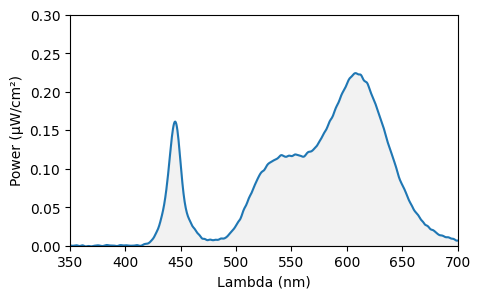

In [39]:
# Load LED data (for white in this case)
file_cal = 'cal_with_MEA2_matias.pkl'
caldata =load_obj(file_cal)

lx = caldata['xnew']
lx[0] = 300

color_order = caldata['orderS']
spec_curves = np.array(caldata['LedSpectra'])
spec_curves[:,0]=0


#--------------------------------------------------------------------------------
# White Spec for Vis Stim
figure()
WhiteVisPower = 25

WhiteVS = spec_curves[5]/np.sum(spec_curves[5])/diff(lx)[10]  * WhiteVisPower

f = interpolate.interp1d(lx,WhiteVS)
newWvis = f(x)/np.sum(f(x))*np.sum(WhiteVS)*diff(lx)[10]/diff(x)[0]

fig , ax = plt.subplots(figsize=(5, 3))

ax.plot(x,newWvis)
ax.fill_between(x,0,newWvis,alpha=0.1, color='grey')

ax.set_xlim([350,700])
ax.set_ylim([0,0.3])
ax.set_xlabel('Lambda (nm)')
ax.set_ylabel('Power (µW/cm²)')

np.sum(newWvis)*diff(x)[10]

In [40]:
# Get effect from White at Vis stim in 2p Setup

ISO_result = IlluminanceFactor(newWvis,Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')


Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :         89
Melanopsin  :      22069
Rhodopsin   :      69974
Mcones      :      33646
Red_opsin   :     102293

Scones      : 8.85e+01
Melanopsin  : 2.21e+04
Rhodopsin   : 7.00e+04
Mcones      : 3.36e+04
Red_opsin   : 1.02e+05


In [41]:
# Get effect from White at OPTO full field

WhiteOptoPower = 71900/correction_f
ISO_result = IlluminanceFactor(newWvis/np.sum(newWvis)*WhiteOptoPower/diff(x)[10],Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)
print('')
Write_fancy(ISO_result,F='scientific')

print('')
# For Chrimson activation -> photons / cm2 / s -> *10^8 /ac  (=*5)
print('For photons / cm / s')
Write_fancy(ISO_result*10**8*5,F='scientific')

Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :     254557
Melanopsin  :   63471241
Rhodopsin   :  201245534
Mcones      :   96767139
Red_opsin   :  294194753

Scones      : 2.55e+05
Melanopsin  : 6.35e+07
Rhodopsin   : 2.01e+08
Mcones      : 9.68e+07
Red_opsin   : 2.94e+08

For photons / cm / s
Scones      : 1.27e+14
Melanopsin  : 3.17e+16
Rhodopsin   : 1.01e+17
Mcones      : 4.84e+16
Red_opsin   : 1.47e+17


# Building (Mouse) White light illumination

## Computations

In [42]:
# Filippo
#----------------------------------------
violet = 0.0214
blue   = 0 
green = 0
yellow = 0.7829
red    = 0

# Filippo
#----------------------------------------
# violet = 0
# blue   = 1 * 0.035
# green = 1 * 0.148
# yellow = 1* 0.5585
# red    = 0

my_light = LEDs[0]*violet + LEDs[1]*blue + LEDs[2]*green + LEDs[3]*yellow + LEDs[4]*red


In [43]:
NDfilter = 0
Transmission =  10**(-NDfilter/10)

LIGHT = (violet*LEDs[0]+blue*LEDs[1]+green*LEDs[2]+yellow*LEDs[3]+red*LEDs[4])*Transmission

ISO_result = IlluminanceFactor(LIGHT,Opsins,x)

print('Results are in: Isomerisations/s - For R* value look for Rhodopsin result\n')
Write_fancy(ISO_result,F=0)

Results are in: Isomerisations/s - For R* value look for Rhodopsin result

Scones      :      24657
Melanopsin  :     985487
Rhodopsin   :    3581652
Mcones      :    1812866
Red_opsin   :    1751466


In [44]:
# Load LED data
file_cal = "cal_with_MEA2_matias.pkl"
caldata =load_obj(file_cal)
print(caldata.keys())

dict_keys(['V', 'Vcurves', 'xnew', 'LedSpectra', 'orderV', 'orderS', 'whiteP'])


In [45]:
caldata['orderV']

['r', 'y', 'g', 'b', 'violet']

In [46]:
lx = caldata['xnew']
lx[0] = 300

color_order = caldata['orderS']
spec_curves = np.array(caldata['LedSpectra'])
spec_curves[:,0]=0

reorder = [1,2,3,4,5]
Vcurves = np.array(caldata['Vcurves'])[:,reorder]

In [47]:
# New interpolated V calibration curves
#---------------------------------------------

Vnew = np.linspace(0,5,5001)
newVcurves = np.zeros([5,5001])
for i in np.arange(5):
    vals = (np. isnan(Vcurves[:,i]))==False
    f = interpolate.interp1d(caldata['V'][vals],Vcurves[:,i][vals],fill_value="extrapolate")
    newVcurves[i] = f(Vnew) / correction_f  # use interpolation function returned by `interp1d`
    newVcurves[i] = np.where(newVcurves[i]<0,0,newVcurves[i]) # take negative extrapolations out


Rmax = np.nanmax(newVcurves[0])
Ymax = np.nanmax(newVcurves[1])
Gmax = np.nanmax(newVcurves[2])
Bmax = np.nanmax(newVcurves[3])
Vmax = np.nanmax(newVcurves[4])

In [48]:
# 1/violet,1/green,Transmission
#Print voltages
print('\nVoltages')
print('redV   ',find_V(red,'r', newVcurves, Vnew),' V')
print('yellowV',find_V(yellow,'y', newVcurves, Vnew),' V')
print('greenV ',find_V(green,'g', newVcurves, Vnew),' V')
print('blueV  ',find_V(blue,'b', newVcurves, Vnew),' V')
print('violetV',find_V(violet,'v', newVcurves, Vnew),' V')



Voltages
redV    0.0  V
yellowV 3.23  V
greenV  0.0  V
blueV   0.0  V
violetV 0.146  V


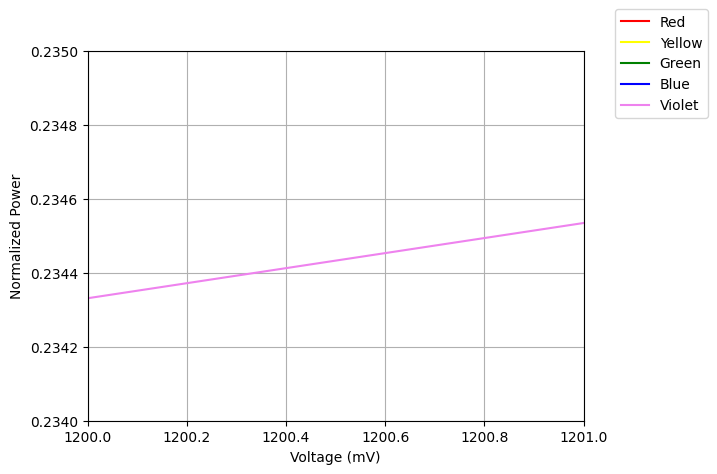

In [49]:
plot(newVcurves[0] / Rmax,color='red')
plot(newVcurves[1] / Ymax,color='yellow')
plot(newVcurves[2] / Gmax,color='green')
plot(newVcurves[3] / Bmax,color='blue')
plot(newVcurves[4] / Vmax,color='violet')
plt.legend(['Red','Yellow','Green','Blue','Violet'], bbox_to_anchor=(1.05, 0.8))
plt.xlabel('Voltage (mV)')
plt.ylabel('Normalized Power')

# TODO make this a function and in a for loop

if violet != 0:
    # plot vertical line at desired voltage
    axvline(x=find_V(violet,'v', newVcurves, Vnew)*1000,color='violet',linestyle='-')

if blue != 0:
    # plot vertical line at desired voltage
    axvline(x=find_V(blue,'b', newVcurves, Vnew)*1000,color='blue',linestyle='--')

if green != 0:
    # plot vertical line at desired voltage
    axvline(x=find_V(green,'g', newVcurves, Vnew)*1000,color='green',linestyle='--')

if yellow != 0:
    # plot vertical line at desired voltage
    axvline(x=find_V(yellow,'y', newVcurves, Vnew)*1000,color='yellow',linestyle='--')

if red != 0:
    # plot vertical line at desired voltage
    axvline(x=find_V(red,'r', newVcurves, Vnew)*1000,color='red',linestyle='--')

# zoom on the interesting part

xlim([1200,1201])
ylim([0.234,0.2350])    

# grid on
grid()